## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [ ]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
train, test = keras.datasets.cifar10.load_data()

In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [ ]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# 比較不同 Batch Size

In [ ]:

def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i, deep in enumerate(num_neurons):
        if i == 0 :
            x = keras.layers.Dense(units= deep, activation='relu', name= 'layer' +str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units = deep, activation='relu', name = 'layer' + str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)

    out = keras.layers.Dense(units = output_units, activation= 'softmax' , name = 'output')(x)

    model = keras.models.Model(inputs=input_layer,outputs=out)
    
    return model

In [ ]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = [32, 128, 256]
MOMENTUM = 0.95

In [ ]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for b_sz in BATCH_SIZE:
    keras.backend.clear_session() #清除
    print(f"Model with Batch Size {b_sz}")
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, momentum = MOMENTUM, nesterov = True)

    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer)
    model.fit(x_train, y_train, epochs = EPOCHS, batch_size = b_sz, validation_data = (x_test,y_test), shuffle = True)

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    name_tag = f"b_size = {b_sz}"
    results[name_tag] = {'train-loss': train_loss,
                        'valid-loss': valid_loss,
                        'train-acc': train_acc,
                        'valid-acc': valid_acc}

Model with Batch Size 32
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
layer1 (Dense)               (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
layer2 (Dense)               (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
layer3 (Dense)               (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch 

In [ ]:
# 畫圖 function
import matplotlib.pyplot as plt
%matplotlib inline

def draw_plt(topic = " "):
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title(f"{topic}:Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title(f"{topic}:Accuracy")
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23519 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35264 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23519 missing from current font.
  font.set_text(s, 0, flags=flags)


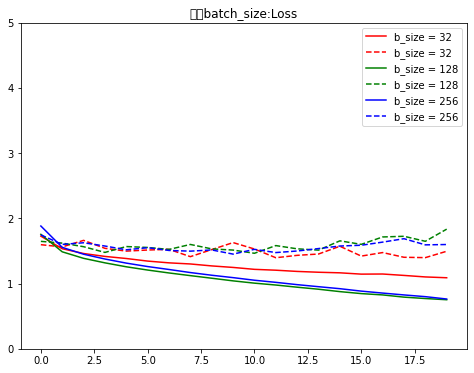

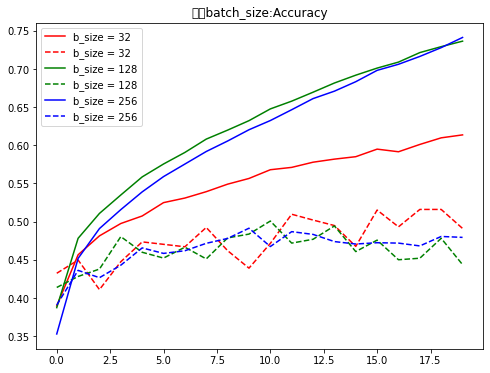

In [ ]:
draw_plt("觀察batch_size")

# size小執行時間較久，但其驗證樣本準確度在較高的epchs看起來較高

# BN 放在 Activation 之前

In [ ]:
# 可以調整BN在Activation前面或後面的 function

def build_mlp_bfactive(input_shape, output_units=10, num_neurons=[512,256,128], pre_activate=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i, deep in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=deep, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            else:
                x = keras.layers.Activation("relu")(x)
                x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=deep, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            else:
                x = keras.layers.Activation("relu")(x)
                x = keras.layers.BatchNormalization()(x)

    out = keras.layers.Dense(units = output_units, activation= 'softmax' , name = 'output')(x)

    model = keras.models.Model(inputs=input_layer,outputs=out)
    
    return model

In [ ]:
"""
設定超參數
"""
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95

results = {}
"""Code Here
"""
keras.backend.clear_session() #清除
print(f"Model BN before activation")
model = build_mlp_bfactive(input_shape = x_train.shape[1:],pre_activate = True)
model.summary()
optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, momentum = MOMENTUM, nesterov = True)

model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer = optimizer)
model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_test,y_test), shuffle = True)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

results = {}
name_tag = f"Before_activation"
results[name_tag] = {'train-loss': train_loss,
                    'valid-loss': valid_loss,
                    'train-acc': train_acc,
                    'valid-acc': valid_acc}

Model BN before activation
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)  

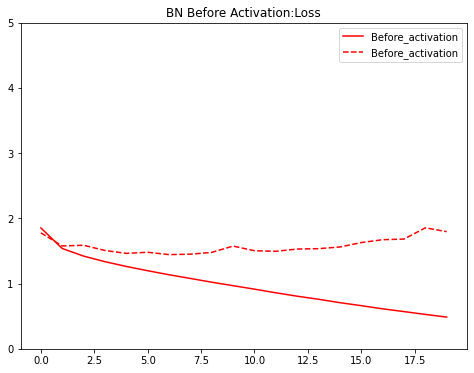

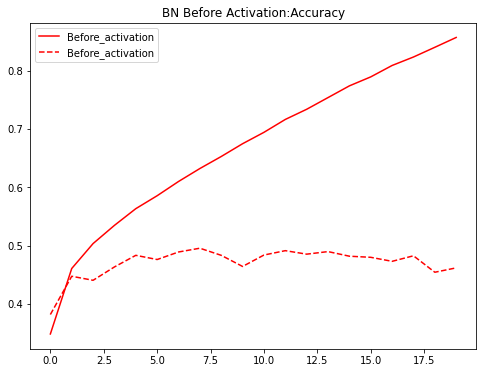

In [ ]:
draw_plt('BN Before Activation')

#BN 放在 Input Layer 後

In [ ]:
def build_mlp_3(input_shape, output_units=10, num_neurons=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i, deep in enumerate(num_neurons):
        if i == 0 :
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units= deep, activation='relu', name= 'layer' +str(i+1))(x)
        else:
            x = keras.layers.Dense(units = deep, activation='relu', name = 'layer' + str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)

    out = keras.layers.Dense(units = output_units, activation= 'softmax' , name = 'output')(x)

    model = keras.models.Model(inputs=input_layer,outputs=out)
    
    return model

In [ ]:
"""
設定超參數
"""
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95

results = {}
"""Code Here
"""
keras.backend.clear_session() #清除
print(f"Model BN before activation")
model = build_mlp_3(input_shape = x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, momentum = MOMENTUM, nesterov = True)

model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer = optimizer)
model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_test,y_test), shuffle = True)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

results = {}
name_tag = f"Before_activation"
results[name_tag] = {'train-loss': train_loss,
                    'valid-loss': valid_loss,
                    'train-acc': train_acc,
                    'valid-acc': valid_acc}

Model BN before activation
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
layer1 (Dense)               (None, 512)               1573376   
_________________________________________________________________
layer2 (Dense)               (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
layer3 (Dense)               (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batc

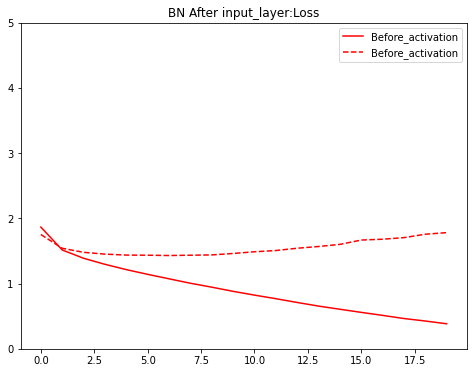

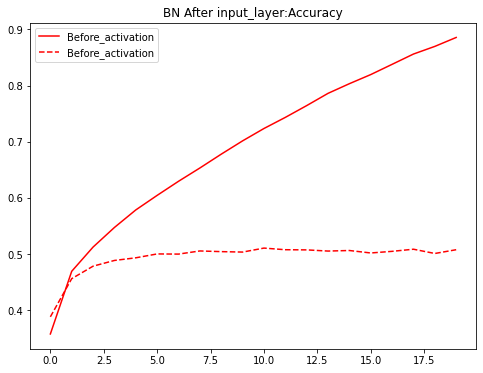

In [ ]:
draw_plt("BN After input_layer")

#看起來測試資料的效果，還挺穩定的